In [2]:
library(xts)
library(tidyr)
library(DBI)
conn <- dbConnect(odbc::odbc(), "JupyterLab", timeout = 10)

---
# 1. Daily intraday correlations from TAQ data

We compute intraday pairwise correlations as
$$
\rho^{ij}_t = \frac{COV(r_t^i,r_t^j)}{SD(r_t^i)SD(r_t^j)},
$$

where $r_i$ are the intraday returns of stock $i$ with frequency $m$ (not written, tbd 1 to 15 minutes), $\rho_t^{ij}$ is the intraday pairwise correlation of stocks $i$ and $j$.

We can then compute
$$
\bar{\rho}_t = \frac{1}{N(N-1)} \sum_{i,j}^{N} \rho^{ij}_t, \; \; \;
\forall i\ne j,
$$

where $\bar{\rho}_t$ is the mean of pairwise correlations on day $t$. We exclude correlations of stocks with themselves and therefore the sum gets divided by $N(N-1)$. The reason for doing so is that adding 500 correlations of 1 would bias the average towards 1.

In [3]:
# Get time index of returns
qry <- "SELECT DISTINCT CONVERT(date,[DATE]) AS [DATE] FROM dbo.TAQ ORDER BY [DATE];"

dbGetQuery(conn, qry) %>%
    .$DATE -> date_index

# Housekeeping
rm(qry)

In [4]:
tmp_avg_corr <- matrix(nrow=0, ncol=2)

for (i in 1:length(date_index)) {
    
    # Build query
    part_qry_1 <- "SELECT SYMBOL, [DATE], PRICE FROM dbo.TAQ WHERE [DATE] < '"
    part_qry_2 <- "' AND [DATE] >= '"
    part_qry_3 <- "';"
    
    qry <- paste0(part_qry_1,
                  date_index[i] + 1,
                  part_qry_2,
                  date_index[i],
                  part_qry_3)
    
    # Get query result
    dbGetQuery(conn, qry) %>%
        pivot_wider(names_from = SYMBOL, values_from = PRICE) -> df
    
    # Convert to xts and replace NAs by last observation
    as.xts(df[,-1], order.by=df$DATE) %>%
        na.locf %>%
        .[endpoints(., on="minutes", k=5),] -> price
    
    # Compute returns and pair-wise correlations
    ret <- price / lag(price, k=1, na.pad=FALSE) - 1
    corr <- cor(ret, use="complete.obs", method="pearson")
    
    # Take mean of daily correlations
    diag(corr) <- NA 
    tmp_avg_corr <- rbind(tmp_avg_corr,
                          c(date_index[i], mean(corr, na.rm=TRUE)))
}

# Build xts object
avg_corr <- xts(tmp_avg_corr[,2],
                 order.by = as.Date(tmp_avg_corr[,1]))
names(avg_corr) <- "Avg.Corr"

# Housekeeping
rm(corr, price, ret, date_index, df, i, part_qry_1, part_qry_2, part_qry_3, qry, tmp_avg_corr)

In [ ]:
# Plan to store series of correlations back in the DB to save time on subsequent executions !

     Index               Avg.Corr      
 Min.   :2001-01-02   Min.   :0.01846  
 1st Qu.:2001-04-01   1st Qu.:0.06981  
 Median :2001-06-28   Median :0.09095  
 Mean   :2001-06-30   Mean   :0.09577  
 3rd Qu.:2001-10-02   3rd Qu.:0.12013  
 Max.   :2001-12-31   Max.   :0.20163  

             Avg.Corr
2001-01-02 0.05046763
2001-01-03 0.15518342
2001-01-04 0.04090213
2001-01-05 0.04667617
2001-01-08 0.05841527
2001-01-09 0.04902957

             Avg.Corr
2001-12-21 0.03745145
2001-12-24 0.02979356
2001-12-26 0.09117936
2001-12-27 0.05246944
2001-12-28 0.08130422
2001-12-31 0.09751247

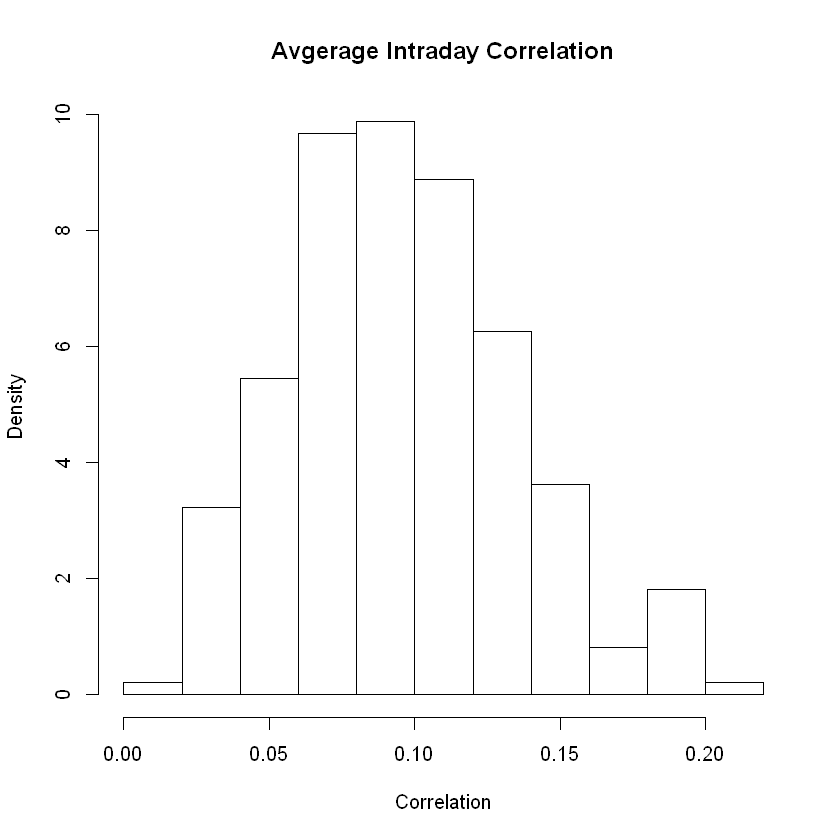

In [6]:
summary(avg_corr)
head(avg_corr)
tail(avg_corr)
hist(avg_corr, freq=F, main="Avgerage Intraday Correlation", xlab="Correlation")

---
# 2. RPNA story count

In this section, we build 4 time series of story count per day:
- total_count
- macro_count - stories containing no mention of any company
- comp_count - stories containing only mentions of companies
- mix_count - stories containg both mentions

In [7]:
qry <-
"SELECT
    ENTITY_TYPE,
    COUNT(DISTINCT RP_STORY_ID) AS NO_STORIES,
    100.0 * COUNT(DISTINCT RP_STORY_ID) / (SELECT COUNT(DISTINCT RP_STORY_ID) FROM dbo.RPNA_WSJ) AS FRAC_STORIES
FROM dbo.RPNA_WSJ
GROUP BY ENTITY_TYPE
ORDER BY NO_STORIES DESC;"

dbGetQuery(conn, qry)

ENTITY_TYPE,NO_STORIES,FRAC_STORIES
<chr>,<int>,<dbl>
COMP,678952,80.3282451
ORGA,416262,49.2488364
CMDT,125606,14.8607112
PLCE,10517,1.2442885
CURR,1286,0.1521494


In [8]:
qry <-
"WITH
 not_comp AS
 (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE<>'COMP'
 ),
 only_comp AS
 (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE='COMP'
 )

 SELECT
    t.[TYPE],
    t.NO_STORIES,
    100.0 * t.NO_STORIES / SUM(NO_STORIES) OVER() AS FRAC_STORIES
 FROM (
    SELECT
        'Only companies mentioned' AS [TYPE],
        COUNT(DISTINCT RP_STORY_ID) AS [NO_STORIES]
    FROM dbo.RPNA_WSJ
    WHERE RP_STORY_ID NOT IN (SELECT * FROM not_comp)

    UNION ALL

    SELECT
        'No companies mentioned',
        COUNT(DISTINCT RP_STORY_ID)
    FROM dbo.RPNA_WSJ
    WHERE RP_STORY_ID NOT IN (SELECT * FROM only_comp)

    UNION ALL

    SELECT
        'Both mentioned',
        COUNT(DISTINCT RP_STORY_ID)
    FROM dbo.RPNA_WSJ
    WHERE RP_STORY_ID IN (SELECT * FROM not_comp)
      AND RP_STORY_ID IN (SELECT * FROM only_comp)
 ) t
 ORDER BY FRAC_STORIES DESC;"

dbGetQuery(conn, qry)

TYPE,NO_STORIES,FRAC_STORIES
<chr>,<int>,<dbl>
Only companies mentioned,371901,44.00039
Both mentioned,307051,36.32785
No companies mentioned,166270,19.67175


In [9]:
# Get count of total stories per day
qry <-
"DECLARE @time_shift int = 0;

 SELECT
    CAST(DATEADD(HOUR, @time_shift, TIMESTAMP_EST) AS date) AS [DATE],
    COUNT(DISTINCT RP_STORY_ID) AS total_count
 FROM dbo.RPNA_WSJ
 GROUP BY CAST(DATEADD(HOUR, @time_shift, TIMESTAMP_EST) AS date)
 ORDER BY [date];"
df <- dbGetQuery(conn, qry)
total_count <- xts(df[,2], order.by=df$DATE) # No need to set time zone as everything is done in SQL and we only work with dates in R.
names(total_count) <- names(df)[2]
head(total_count)

           total_count
2001-01-01          94
2001-01-02           1
2001-01-03          89
2001-01-04         115
2001-01-05          36
2001-01-07          95

In [10]:
# Get count of non-company stories per day
qry <-
"DECLARE @time_shift int = 0;

 SELECT
    CAST(DATEADD(HOUR, @time_shift, TIMESTAMP_EST) AS date) AS [DATE],
    COUNT(DISTINCT RP_STORY_ID) AS macro_count
 FROM dbo.RPNA_WSJ
 WHERE RP_STORY_ID NOT IN (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE='COMP'
 )
 GROUP BY CAST(DATEADD(HOUR, @time_shift, TIMESTAMP_EST) AS date)
 ORDER BY [date];"
df <- dbGetQuery(conn, qry)
macro_count <- xts(df[,2], order.by=df$DATE) # No need to set time zone as everything is done in SQL and we only work with dates in R.
names(macro_count) <- names(df)[2]
head(macro_count)

           macro_count
2001-01-01           9
2001-01-03          11
2001-01-04          15
2001-01-05           4
2001-01-07          15
2001-01-08          16

In [11]:
# Get count of companies-only stories per day
qry <-
"DECLARE @time_shift int = 0;

 SELECT
    CAST(DATEADD(HOUR, @time_shift, TIMESTAMP_EST) AS date) AS [DATE],
    COUNT(DISTINCT RP_STORY_ID) AS comp_count
 FROM dbo.RPNA_WSJ
 WHERE RP_STORY_ID NOT IN (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE<>'COMP'
 )
 GROUP BY CAST(DATEADD(HOUR, @time_shift, TIMESTAMP_EST) AS date)
 ORDER BY [date];"
df <- dbGetQuery(conn, qry)
comp_count <- xts(df[,2], order.by=df$DATE) # No need to set time zone as everything is done in SQL and we only work with dates in R.
names(comp_count) <- names(df)[2]
head(comp_count)

           comp_count
2001-01-01         49
2001-01-03         40
2001-01-04         49
2001-01-05         18
2001-01-07         46
2001-01-08         62

In [12]:
# Merge counts
news <- merge(total_count, macro_count, fill=0, join="outer")
news <- merge(news, comp_count, fill=0, join="outer")

# Mix_count contains stories that include both companies and non-company entities
news$mix_count <- news$total_count - (news$macro_count + news$comp_count)
head(news)

# Housekeeping
rm(total_count, macro_count, comp_count, df)

           total_count macro_count comp_count mix_count
2001-01-01          94           9         49        36
2001-01-02           1           0          0         1
2001-01-03          89          11         40        38
2001-01-04         115          15         49        51
2001-01-05          36           4         18        14
2001-01-07          95          15         46        34

---

# 3. Analysis

From section 1, we have the daily average correlations $\bar{\rho}_t$. This is our dependent variable. From section 2, we get four time series of story counts:

- total_count
- macro_count - stories containing no mention of any company
- comp_count - stories containing only mentions of companies
- mix_count - stories containg both mentions

that we use to build a daily ratio of macro news to total news in the following way

$$
R_t = \frac{NE_t}{NE_t + E_t},
$$

where $NE_t$ is the count of macro (non-equity) news and $E_t$ is the count of equity news on day $t$.

We would then estimate the regression equation
$$
\bar{\rho}_t = \alpha + \beta_0 L^0(R_t) + \beta_1 L^1(R_t) + \dots + \beta_k L^k(R_t) + \epsilon_t,
$$
where $L^k$ is the lag operator.

In [17]:
# Merge datasets
# (How should we lag the news?)
d <- merge(avg_corr, news, join="inner")

# Prepare data
# (tbd which ratio makes more sense)
#ratio <- (d$macro_count + d$mix_count) / d$total_count
ratio <- d$macro_count / d$total_count
names(ratio) <- "ratio"
d <- merge(d, ratio, join="inner")
head(d)
tail(d)

# Estimate model
fit <- lm(d$Avg.Corr ~ lag(d$ratio, k=0))
summary(fit)

             Avg.Corr total_count macro_count comp_count mix_count     ratio
2001-01-02 0.05046763           1           0          0         1 0.0000000
2001-01-03 0.15518342          89          11         40        38 0.1235955
2001-01-04 0.04090213         115          15         49        51 0.1304348
2001-01-05 0.04667617          36           4         18        14 0.1111111
2001-01-08 0.05841527         149          16         62        71 0.1073826
2001-01-09 0.04902957         118          14         67        37 0.1186441

             Avg.Corr total_count macro_count comp_count mix_count     ratio
2001-12-20 0.07582562         150          30         67        53 0.2000000
2001-12-21 0.03745145          38           7         16        15 0.1842105
2001-12-26 0.09117936          84          16         41        27 0.1904762
2001-12-27 0.05246944         103          20         41        42 0.1941748
2001-12-28 0.08130422          38           5         17        16 0.1315789
2001-12-31 0.09751247          18           9          3         6 0.5000000


Call:
lm(formula = d$Avg.Corr ~ lag(d$ratio, k = 0))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.072753 -0.026456 -0.004385  0.023547  0.103443 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.075029   0.007572   9.909  < 2e-16 ***
lag(d$ratio, k = 0) 0.130525   0.044602   2.926  0.00375 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03791 on 245 degrees of freedom
Multiple R-squared:  0.03378,	Adjusted R-squared:  0.02983 
F-statistic: 8.564 on 1 and 245 DF,  p-value: 0.003751


## Results

Need to add more data before having a look at the results. Currently only 6 months in 2001.

---
# 4. To-Do's
- Normalize intraday returns by market beta? If yes, use unconditional betas.
- Decide whether to define macro news as no equity or no equity + both.
- Instead of raw ratio of story count, try to weight count by news sentiment or novelty
- Improve story count based on market opening time
- Include weekend news in Monday count?